predict outcome = live release through adoption

or 

dead release (deceased, euthanized, disposal,
missing)

Goal is for shelter to be no kill.

Questions to answer:
Does cat breed affect outcome?
Does age affect outcome? Do kittens have more live releases?
Does sex affect outcome?
Does having a name affect outcome?

Notes:
SCRP - stray cat return program (TNR)

In [ ]:
!pip install graphviz

### Import Necessary Libraries

In [1]:
import pandas as pd
from sodapy import Socrata
import config
import numpy as np
import datetime

import pandas as pd
pd.set_option("display.max_columns", 2200)
pd.set_option("display.max_rows", 200)
import numpy as np
import seaborn  as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline  
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations
import re
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Keeping track of runtime.
import timeit
from pprint import pprint

# Decision trees
from sklearn import tree
from IPython.display import Image

# Packages for rendering tree.
import pydotplus
import graphviz

import itertools #(for confusion matrix)
from sklearn.model_selection import RandomizedSearchCV

### Import Data

In [2]:
# intake database
intakes = pd.read_csv('austin_animal_center_intakes.csv')

In [3]:
# outcome database
out = pd.read_csv('austin_animal_center_outcomes.csv')

### Cleaning and EDA

In [4]:
# some initial data transformation

def transform_age(df, age_column):
    df = df.loc[df.loc[:, age_column] != 'NULL']
    range_column = age_column +'_calen_time'
    #calen_time: if intake age is in weeks, calen_time = 7
    #            if intake age is in months, calen_time = 30
    #            if intake age is in years, calen_time = 365
    df['age_in_d_w_or_y'], df[range_column] = df.loc[:, age_column].str.split(' ').str[0].fillna(0).astype(int), df.loc[:, age_column].str.split(' ').str[1].fillna(0)
    df[range_column] = np.where(df[range_column].str.contains('day'), 1, 
                                  np.where(df[range_column].str.contains('week'), 7, 
                                           np.where(df[range_column].str.contains('month'), 30, 
                                                    np.where(df[range_column].str.contains('year'), 365, 0)))).astype(int)
    df[age_column + '_in_days'] = df[range_column] * df['age_in_d_w_or_y']
    df[age_column + '_in_years'] = df[age_column + '_in_days'] / 365
    return df

def transform_date(df, event):
    event_date = event + '_datetime'
    df[event_date] = pd.to_datetime(df['datetime'])
    df[event + '_month'] = df[event_date].dt.month
    df[event + '_year'] = df[event_date].dt.year
    df[event + '_weekday'] = df[event_date].dt.weekday_name
    df.rename(columns={event + '_name': 'name'}, inplace=True)
    return df

def create_unique_id(df, event):
    df.reset_index(inplace=True)
                   
    df[event + '_number'] = df.groupby(['animal_id'])[event + '_datetime'].rank(method='dense', ascending=False)
    df['animal_id_new'] = df['animal_id'] + '_' + df[event + '_number'].astype(int).astype(str)
    return df
    
def transform_birthdates(df):
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
    df['dob_year'] = df['date_of_birth'].dt.year
    df['dob_month'] = df['date_of_birth'].dt.month
    return df

In [5]:
#running initial data transformations

intakes = transform_age(intakes, 'age_upon_intake')
intakes = transform_date(intakes, 'intake')

intakes.reset_index(inplace=True)

intakes['intake_number'] = intakes.groupby(['animal_id'])['intake_datetime'].rank(method='dense', ascending=False)
intakes['animal_id_new'] = intakes['animal_id'] + '_' + intakes['intake_number'].astype(int).astype(str)

out = transform_age(out, 'age_upon_outcome')
out = transform_date(out, 'outcome')
out = create_unique_id(out, 'outcome')
out = transform_birthdates(out)

In [6]:
#dropping unneccessary columns

cols_to_drop = ['Unnamed: 0', 'index']

out.drop(['animal_type', 'breed', 'color', 'age_in_d_w_or_y'] + cols_to_drop, axis=1, inplace=True)
intakes.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
# merge intake and outcome databases

out.set_index('animal_id_new', inplace=True)
intakes.set_index('animal_id_new', inplace=True)

df = pd.merge(out, intakes, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

In [8]:
#dropping unneccessary columns

col_to_drop = ['age_upon_outcome_calen_time', 'animal_id_outcome', 'outcome_number', 
'dob_year', 'age_upon_outcome_calen_time', 'animal_id_outcome', 'outcome_number', 'dob_year', 
'animal_id_intake', 'found_location', 'age_in_d_w_or_y', 'age_upon_intake_calen_time']

df.drop(col_to_drop, axis=1, inplace=True)

In [9]:
#creating new columns of time in shelter, ages at intake and outcome and intake and outcome dates

df['time_in_shelter'] = df['outcome_datetime'] - df['intake_datetime']
df['age_at_intake'] = df['intake_datetime'] - df['date_of_birth']
df['age_at_outcome'] = df['outcome_datetime'] - df['date_of_birth']
df['intake_date'] = pd.to_datetime(df['intake_datetime']).dt.date
df['outcome_date'] = pd.to_datetime(df['datetime_outcome']).dt.date

In [10]:
#dropping unneccessary columns

df.drop(['date_of_birth','datetime_intake', 'datetime2', 'age_upon_intake', 
         'dob_month', 'outcome_datetime'], axis=1, inplace=True)

In [11]:
df[df['animal_type']=='Dog']['outcome_type'].value_counts()

Adoption           26815
Return to Owner    16628
Transfer           12470
Euthanasia          1605
Rto-Adopt            332
Died                 209
Missing               23
Disposal              14
Name: outcome_type, dtype: int64

In [12]:
df[df['animal_type']=='Cat']['outcome_type'].value_counts()

Transfer           16895
Adoption           16521
Return to Owner     1862
Euthanasia          1685
Died                 555
Rto-Adopt             75
Missing               34
Disposal              22
Name: outcome_type, dtype: int64

In [13]:
#cats kill rate

(1685+555+34+22)/16521

0.13897463833908358

In [14]:
#dogs kill rate

(1605+209+23+14)/26815

0.0690285288085027

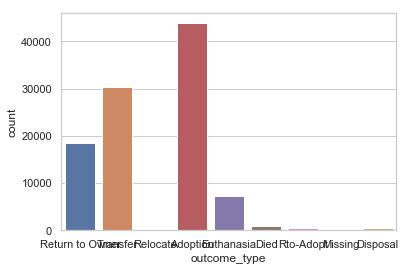

In [15]:
sns.countplot(df['outcome_type'])

In [16]:
# Get names of indexes for which animal type column value is not cat

indexNames = df[ df['animal_type']!='Cat'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [17]:
df['outcome_type'].value_counts()

Transfer           16895
Adoption           16521
Return to Owner     1862
Euthanasia          1685
Died                 555
Rto-Adopt             75
Missing               34
Disposal              22
Name: outcome_type, dtype: int64

In [18]:
#making outcome_type binary

df['outcome_type'] = df['outcome_type'].replace(['Adoption'], 1)
df['outcome_type'] = df['outcome_type'].replace(['Euthanasia', 'Died', 'Disposal',
                                                'Missing'], 0)
df['outcome_type'] = df['outcome_type'].replace(['Transfer', 'Return to Owner', 'Rto-Adopt'], 3)
df.rename(index=str, columns={'outcome_type': 'adopted'}, inplace=True)

In [19]:
# Get names of indexes for which live_release value is not 0 or 1 and drop those rows
indexNames = df[df['adopted']==3].index

# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

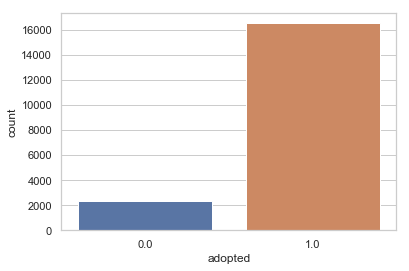

In [20]:
sns.countplot(df['adopted'])

In [21]:
df['adopted'].value_counts()

1.0    16521
0.0     2296
Name: adopted, dtype: int64

In [22]:
#making name column binary: 0 for no name, 1 for named

df['name_outcome'].fillna(0, inplace=True)
df["name_outcome"]=df["name_outcome"].apply(lambda x: 1 if x!=0 else 0)

df.drop('name_intake', axis=1, inplace=True)

In [23]:
df=df.drop('outcome_subtype', axis=1)

## Feature Engineering

In [24]:
# Bin Ages
bins = [0, 120, 365, 3285, 8030]
in_life_stages = pd.cut(df['age_upon_intake_in_days'], bins)
# Create dummy variables for 'age_range'
in_life_stage_dummies = pd.get_dummies(in_life_stages, prefix="int_age_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, in_life_stage_dummies], axis=1)

In [25]:
# Bin Ages
bins = [0, 120, 365, 3285, 8030]
out_life_stage = pd.cut(df['age_upon_outcome_in_days'], bins)
# Create dummy variables for 'age_range'
out_life_stage_dummies = pd.get_dummies(out_life_stage, prefix="out_age_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, out_life_stage_dummies], axis=1)

In [26]:
# Build a season_column and dummy for intakes

seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']

df['intake_season'] = df['intake_date'].map(lambda x: seasons[x.month-1])

int_season_dummies = pd.get_dummies(df['intake_season'], prefix="int_season_")
int_season_dummies.head()

df = pd.concat([df, int_season_dummies],axis=1)

to_drop = ['intake_date', 'intake_season', 'age_upon_intake_in_days',
          'age_upon_intake_in_years', 'age_upon_intake_in_years',
          'age_at_intake', 'intake_month']
df.drop(to_drop, axis=1, inplace=True)

In [27]:
# Build a season_column and dummy for outcomes

seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']

df['outcome_season'] = df['outcome_date'].map(lambda x: seasons[x.month-1])

out_season_dummies = pd.get_dummies(df['outcome_season'], prefix="out_season_", drop_first=True)
out_season_dummies.head()

df = pd.concat([df, out_season_dummies],axis=1)

to_drop = ['outcome_date', 'outcome_season', 'age_upon_outcome_in_days',
          'age_upon_outcome_in_years', 'age_upon_outcome_in_years',
          'age_at_outcome', 'age_upon_outcome', 'outcome_month']
df.drop(to_drop,axis=1, inplace=True)

In [28]:
#making outcome and intake days binary: 1 for weekday and 0 for weekend

df['outcome_weekday'] = df['outcome_weekday'].replace(['Monday', 'Tuesday',
                                                    'Wednesday', 'Thursday', 'Friday'], 1)
df['outcome_weekday'] = df['outcome_weekday'].replace(['Saturday', 'Sunday'], 0)
df['intake_weekday'] = df['intake_weekday'].replace(['Monday', 'Tuesday',
                                                    'Wednesday', 'Thursday', 'Friday'], 1)
df['intake_weekday'] = df['intake_weekday'].replace(['Saturday', 'Sunday'], 0)

In [29]:
# Get names of indexes for which column animal_type has value Bird
indexNames = df[df['animal_type'] == 'Bird'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# Get names of indexes for which column animal_type has value Other
indexNames = df[df['animal_type'] == 'Other'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# Get names of indexes for which column animal_type has value Livestock
indexNames = df[df['animal_type'] == 'Livestock'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [30]:
#dropping unneccessary columns

to_drop = ['intake_datetime', 'intake_year', 'datetime_outcome', 'monthyear', 'outcome_year']

df.drop(to_drop, axis=1, inplace=True)

In [31]:
#split intake neuter/spay/sex column:

# new data frame with split value columns 
new = df['sex_upon_intake'].str.split(" ", n = 1, expand = True) 
  
# making separate spay/neuter column from new data frame 
df['int_neut_spay']= new[0] 
      
# Dropping old columns 
df.drop(columns =['sex_upon_intake'], inplace = True) 
  
#split outcome neuter/spay/sex column:
    
# new data frame with split value columns 
new = df['sex_upon_outcome'].str.split(" ", n = 1, expand = True) 
  
# making separate spay/neuter column from new data frame 
df['out_neut_spay']= new[0] 

# making separate sex column from new data frame 
df['female']= new[1] 
  
# Dropping old columns 
df.drop(columns =['sex_upon_outcome'], inplace = True) 

In [32]:
# make sex column binary

df['female'] = [1 if x== 'Female' else 0 for x in df['female']]

In [33]:
#1 for cat/dog is spayed or neutured
#0 for intact and other

df['int_neut_spay'] = df['int_neut_spay'].replace(['Intact', 'Spayed', 'Neutered', 'Unknown'], [0, 1, 1, 0])
df['out_neut_spay'] = df['out_neut_spay'].replace(['Intact', 'Spayed', 'Neutered', 'Unknown'], [0, 1, 1, 0])

In [34]:
#dummy animal_type category

animal_type_dummies = pd.get_dummies(df['animal_type'], prefix="animal_type_")
animal_type_dummies.head()

df = pd.concat([df, animal_type_dummies],axis=1)
df.drop('animal_type',axis=1, inplace=True)

In [35]:
# make intake condition binary: 1 for normal

df['intake_condition'] = [1 if x== 'Normal' else 0 for x in df['intake_condition']]

In [36]:
#dummy intake_type

intake_type_dummies = pd.get_dummies(df['intake_type'], prefix="int_type_")
intake_type_dummies.head()

df = pd.concat([df, intake_type_dummies],axis=1)
df.drop('intake_type',axis=1, inplace=True)

In [37]:
#change time in sheler type to timedelta

df['time_in_shelter'] = df['time_in_shelter'].astype('timedelta64[D]')

In [38]:
# drop rows with time in shelter that is less than 0

# Get names of indexes for which column Age has value 30
indexNames = df[ df['time_in_shelter'] <0].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [39]:
# Bin time in shelter

bins = [0, 30, 365, 1469]
days_in_shelter = pd.cut(df['time_in_shelter'], bins)
# Create dummy variables for 'time in shelter'
days_in_shelter_dummies = pd.get_dummies(days_in_shelter, prefix="days_in_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, days_in_shelter_dummies], axis=1)

df.drop('time_in_shelter', axis=1, inplace=True)

In [40]:
df.head(1)

,name_outcome,adopted,outcome_weekday,breed,color,intake_condition,intake_weekday,intake_number,"int_age__(0, 120]","int_age__(120, 365]","int_age__(365, 3285]","int_age__(3285, 8030]","out_age__(0, 120]","out_age__(120, 365]","out_age__(365, 3285]","out_age__(3285, 8030]",int_season__fall,int_season__spring,int_season__summer,int_season__winter,out_season__spring,out_season__summer,out_season__winter,int_neut_spay,out_neut_spay,female,animal_type__Cat,int_type__Euthanasia Request,int_type__Owner Surrender,int_type__Public Assist,int_type__Stray,"days_in__(0, 30]","days_in__(30, 365]","days_in__(365, 1469]"
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A214991_1,1,0.0,0,Domestic Shorthair,Black,0,0,1.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0


In [41]:
# making breed lowercase

df['breed'] = df['breed'].str.lower()

In [42]:
# creating mix column 

df['mix'] = np.where(df['breed'].str.contains("mix"), 1, 0)

In [45]:
# Creating a temporary breed_edit column.
# Dropping "mix", replacing "medium hair" with "mediumhair" for consistency, and lower-casing.

df['breed_edit'] = df['breed'].str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [50]:
# create a list of cfa (cat fanciers association) breeds

cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

cfa_breeds

'abyssinian|american bobtail|american curl|american shorthair|american wirehair|balinese|bengal|birman|bombay|british shorthair|burmese|burmilla|chartreux|colorpoint shorthair|cornish rex|devon rex|egyptian mau|european burmese|exotic|havana brown|japanese bobtail|korat|laperm|maine coon|manx|norwegian forest cat|ocicat|oriental|persian|ragamuffin|ragdoll|russian blue|scottish fold|selkirk rex|siamese|siberian|singapura|somali|tonkinese|turkish angora|turkish van'

In [53]:
# splitting records with two 'breeds' into two columns for each breed
# some data in the breed columns contains both the fur type and an actual breed
# if the data is just fur type with no breed, the breed is labelled as domestic
# if the data contains a breed in the cfa list, the breed is labelled as cfa breed


df = pd.concat([df, df['breed_edit'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

# If the columns is in the cfa list, mark as 1.

df['cfa_breed'] = np.where((df['breed1'].str.contains(cfa_breeds)) | 
                                (df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

# If neither breed1 or breed2 columns contain a cfa recognized breed, mark as domestic.

df['domestic_breed'] = np.where((df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (df['breed2'].str.contains(cfa_breeds) == False), 
                                     1, 0)

In [56]:
# drop unnecessary columns

In [57]:
df.drop(['breed_edit', 'breed1', 'breed2', 'breed'], axis=1, inplace=True)

In [58]:
#df.drop('mix', axis=1, inplace=True)

In [59]:
df['domestic_breed'].value_counts()

1    17692
0     1079
Name: domestic_breed, dtype: int64

In [66]:
df.head()

,name_outcome,adopted,outcome_weekday,intake_condition,intake_weekday,intake_number,"int_age__(0, 120]","int_age__(120, 365]","int_age__(365, 3285]","int_age__(3285, 8030]","out_age__(0, 120]","out_age__(120, 365]","out_age__(365, 3285]","out_age__(3285, 8030]",int_season__fall,int_season__spring,int_season__summer,int_season__winter,out_season__spring,out_season__summer,out_season__winter,int_neut_spay,out_neut_spay,female,animal_type__Cat,int_type__Euthanasia Request,int_type__Owner Surrender,int_type__Public Assist,int_type__Stray,"days_in__(0, 30]","days_in__(30, 365]","days_in__(365, 1469]",mix,cfa_breed,domestic_breed,coat__agouti,coat__apricot,coat__black,coat__black,coat__black tiger,coat__blue,coat__blue,coat__blue cream,coat__brown,coat__brown,coat__brown merle,coat__brown tiger,coat__buff,coat__calico,coat__chocolate,coat__chocolate,coat__cream,coat__cream,coat__fawn,coat__flame,coat__flame,coat__gray,coat__gray,coat__lilac,coat__lilac,coat__lynx,coat__lynx,coat__orange,coat__orange,coat__orange tiger,coat__red,coat__sable,coat__seal,coat__seal,coat__silver,coat__silver,coat__silver lynx,coat__silver lynx,coat__tan,coat__torbie,coat__tortie,coat__tricolor,coat__white,coat__yellow
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A214991_1,1,0.0,0,0,0,1.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A258441_1,1,0.0,1,0,1,1.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A261770_1,1,0.0,1,1,1,1.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A282897_1,1,1.0,0,1,1,1.0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A282897_2,1,1.0,0,1,1,2.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
# similar to how I needed to transform the breed column
# coat patterns for cats
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [61]:
# create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(tabby|tortie|tortoiseshell|calico|smoke|torbie|colorpoint|point|brindle|agouti|bicolor|tricolor)'

In [62]:
# extracting coat pattern from color and removing it from color column
df['color'] = df['color'].str.lower()

df['coat_pattern'] = df['color'].str.extract(coat_reg, expand=False)

df['color_edit'] = df['color'].str.replace(coat_reg, '').str.strip()

In [63]:
# splitting color column into two color columns
df = pd.concat([df, df['color_edit'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

# replacing blanks in color1 with 'breed specific'.
df['color1'] = np.where(df['color1'] == '', 'breed specific', df['color1'])

# creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
df['coat'] = np.where(df['color1'] == 'breed specific', df['coat_pattern'], df['color1'])

In [64]:
df.drop(['coat_pattern', 'color_edit', 'color1', 'color2', 'color'], axis=1, inplace=True)

In [65]:
# dummy animal coat category

coat_dummies = pd.get_dummies(df['coat'], prefix="coat_")
coat_dummies.head()

df = pd.concat([df, coat_dummies],axis=1)
df.drop('coat', axis=1, inplace=True)

In [67]:
#drop the 4 nans that were still in table

df = df.dropna(how='any')           # assign back
df.dropna(how='any', inplace=True)  # set inplace parameter

In [68]:
df.drop(columns=['animal_type__Cat'],inplace=True)

In [69]:
# make intake number column binary

df['intake_number'] = [0 if x== 1.0 else 1 for x in df['intake_number']]

In [ ]:
# #split color column:

# # new data frame with split value columns 
# new = df['color'].str.split("/", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['color_1']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['color'], inplace = True) 

In [ ]:
# # split color column

# new = df['color_1'].str.split(" ", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['color']= new[0] 

# # Dropping old columns
# df.drop(columns =['color_1'], inplace = True) 

In [ ]:
# #replacing colors of animals with low observations to others

# df['color'] = df['color'].replace(['Yellow', 'Fawn', 'Buff', 'Lynx', 
#                                    'Seal', 'Silver', 'Flame', 'Gold', 
#                                    'Lilac', 'Apricot', 'Liver', 'Agouti', 
#                                    'Pink', 'Ruddy', 'Tan', 'Tricolor', 'Red', 'Sable'], 'Other')
# df['color'] = df['color'].replace(['Chocolate'], 'Brown')


In [ ]:
# #split breed column:

# # new data frame with split value columns 
# new = df['breed'].str.split("/", n = 2, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['breed_1']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['breed'], inplace = True) 

In [ ]:
# #changing the same bt multiply names breeds into single categories 

# df['breed_1'] = df['breed_1'].replace(['Domestic Shorthair Mix', 'American Shorthair', 'American Shorthair Mix', 
#                                        'Domestic Shorthair'], 'Domestic_Short_Hair')
# df['breed_1'] = df['breed_1'].replace(['Domestic Medium Hair Mix', 'Domestic Medium Hair'], 'Domestic_Medium_Hair_Mix')
# df['breed_1'] = df['breed_1'].replace(['Domestic Longhair Mix', 'Domestic Longhair'], 'Domestic_Longhair')
# df['breed_1'] = df['breed_1'].replace(['Domestic Longhair Mix', 'Domestic Longhair'], 'Domestic_Longhair')
# df['breed_1'] = df['breed_1'].replace(['Siamese Mix'], 'Siamese')

In [ ]:
# #split color column:

# # new data frame with split value columns 
# new = df['breed_1'].str.split(" ", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['breed']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['breed_1'], inplace = True) 

In [ ]:
# #replacing breeds of animals with low observations to others (this may be redundant
# #based on following code)

# #replacing breeds of animals with low observations to others

# a = df.breed.value_counts()
# m = df.breed.isin(a.index[a<100])


# df.loc[m, 'breed'] = 'Other'


In [ ]:
# #dummy breeds

# breed_dummies = pd.get_dummies(df['breed'], prefix="breed")
# breed_dummies.head()

# df = pd.concat([df, breed_dummies],axis=1)
# df.drop(['breed'], axis=1, inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18770 entries, A214991_1 to A798165_1
Data columns (total 78 columns):
name_outcome                    18770 non-null int64
adopted                         18770 non-null float64
outcome_weekday                 18770 non-null int64
intake_condition                18770 non-null int64
intake_weekday                  18770 non-null int64
intake_number                   18770 non-null int64
int_age__(0, 120]               18770 non-null uint8
int_age__(120, 365]             18770 non-null uint8
int_age__(365, 3285]            18770 non-null uint8
int_age__(3285, 8030]           18770 non-null uint8
out_age__(0, 120]               18770 non-null uint8
out_age__(120, 365]             18770 non-null uint8
out_age__(365, 3285]            18770 non-null uint8
out_age__(3285, 8030]           18770 non-null uint8
int_season__fall                18770 non-null uint8
int_season__spring              18770 non-null uint8
int_season__summer              18

In [71]:
df.head(5)

,name_outcome,adopted,outcome_weekday,intake_condition,intake_weekday,intake_number,"int_age__(0, 120]","int_age__(120, 365]","int_age__(365, 3285]","int_age__(3285, 8030]","out_age__(0, 120]","out_age__(120, 365]","out_age__(365, 3285]","out_age__(3285, 8030]",int_season__fall,int_season__spring,int_season__summer,int_season__winter,out_season__spring,out_season__summer,out_season__winter,int_neut_spay,out_neut_spay,female,int_type__Euthanasia Request,int_type__Owner Surrender,int_type__Public Assist,int_type__Stray,"days_in__(0, 30]","days_in__(30, 365]","days_in__(365, 1469]",mix,cfa_breed,domestic_breed,coat__agouti,coat__apricot,coat__black,coat__black,coat__black tiger,coat__blue,coat__blue,coat__blue cream,coat__brown,coat__brown,coat__brown merle,coat__brown tiger,coat__buff,coat__calico,coat__chocolate,coat__chocolate,coat__cream,coat__cream,coat__fawn,coat__flame,coat__flame,coat__gray,coat__gray,coat__lilac,coat__lilac,coat__lynx,coat__lynx,coat__orange,coat__orange,coat__orange tiger,coat__red,coat__sable,coat__seal,coat__seal,coat__silver,coat__silver,coat__silver lynx,coat__silver lynx,coat__tan,coat__torbie,coat__tortie,coat__tricolor,coat__white,coat__yellow
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A214991_1,1,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A258441_1,1,0.0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A261770_1,1,0.0,1,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
A282897_1,1,1.0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A282897_2,1,1.0,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
df['adopted'] = df['adopted'].astype(int)

## Basline Modelling

In [73]:
#running a baseline model

target = pd.DataFrame(df, columns = ['adopted'])
features = df.drop(['adopted'], axis=1)

regression = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=17, test_size=0.2)

# crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
# baseline = np.mean(cross_val_score(regression, , y, scoring="r2", cv=crossvalidation))


#create our estimator
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))
print('Test F1 Score: ', f1_score(y_test, lr_y_pred))
print('Test Accuracy Score: ', accuracy_score(y_test, lr_y_pred))

[[ 366   95]
 [  28 3265]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       461
           1       0.97      0.99      0.98      3293

   micro avg       0.97      0.97      0.97      3754
   macro avg       0.95      0.89      0.92      3754
weighted avg       0.97      0.97      0.97      3754

Test F1 Score:  0.9815120998045994
Test Accuracy Score:  0.9672349493873202


## Feature Selection

### Use F-Test to View Top Variables

In [84]:
selector=SelectKBest(f_regression, k=40)
selector.fit(X_train, y_train)
best_columns = X_train.columns[selector.get_support()]
other_columns = X_train.columns[~selector.get_support()]

In [85]:
list(best_columns)

['name_outcome',
 'outcome_weekday',
 'intake_condition',
 'intake_weekday',
 'intake_number',
 'int_age__(0, 120]',
 'int_age__(365, 3285]',
 'int_age__(3285, 8030]',
 'out_age__(0, 120]',
 'out_age__(120, 365]',
 'out_age__(365, 3285]',
 'out_age__(3285, 8030]',
 'int_season__fall',
 'out_season__spring',
 'out_season__summer',
 'out_season__winter',
 'out_neut_spay',
 'female',
 'int_type__Euthanasia Request',
 'int_type__Owner Surrender',
 'int_type__Stray',
 'days_in__(0, 30]',
 'days_in__(30, 365]',
 'mix',
 'coat__black',
 'coat__blue',
 'coat__brown merle',
 'coat__buff',
 'coat__calico',
 'coat__cream ',
 'coat__gray',
 'coat__lilac ',
 'coat__orange ',
 'coat__red',
 'coat__seal',
 'coat__tan',
 'coat__torbie',
 'coat__tricolor',
 'coat__white',
 'coat__yellow']

In [86]:
list(other_columns)

['int_age__(120, 365]',
 'int_season__spring',
 'int_season__summer',
 'int_season__winter',
 'int_neut_spay',
 'int_type__Public Assist',
 'days_in__(365, 1469]',
 'cfa_breed',
 'domestic_breed',
 'coat__agouti',
 'coat__apricot',
 'coat__black ',
 'coat__black tiger',
 'coat__blue ',
 'coat__blue cream',
 'coat__brown',
 'coat__brown ',
 'coat__brown tiger',
 'coat__chocolate',
 'coat__chocolate ',
 'coat__cream',
 'coat__fawn',
 'coat__flame',
 'coat__flame ',
 'coat__gray ',
 'coat__lilac',
 'coat__lynx',
 'coat__lynx ',
 'coat__orange',
 'coat__orange tiger',
 'coat__sable',
 'coat__seal ',
 'coat__silver',
 'coat__silver ',
 'coat__silver lynx',
 'coat__silver lynx ',
 'coat__tortie']

### Use Recursive Feature Elimination

In [87]:
ols = linear_model.LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
   step=1, verbose=0)

In [88]:
selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]

In [89]:
len(list(selected_columns))

8

In [90]:
list(selected_columns)

['int_type__Euthanasia Request',
 'int_type__Owner Surrender',
 'int_type__Public Assist',
 'int_type__Stray',
 'coat__agouti',
 'coat__apricot',
 'coat__chocolate ',
 'coat__fawn']

In [91]:
list(removed_columns)

['name_outcome',
 'outcome_weekday',
 'intake_condition',
 'intake_weekday',
 'intake_number',
 'int_age__(0, 120]',
 'int_age__(120, 365]',
 'int_age__(365, 3285]',
 'int_age__(3285, 8030]',
 'out_age__(0, 120]',
 'out_age__(120, 365]',
 'out_age__(365, 3285]',
 'out_age__(3285, 8030]',
 'int_season__fall',
 'int_season__spring',
 'int_season__summer',
 'int_season__winter',
 'out_season__spring',
 'out_season__summer',
 'out_season__winter',
 'int_neut_spay',
 'out_neut_spay',
 'female',
 'days_in__(0, 30]',
 'days_in__(30, 365]',
 'days_in__(365, 1469]',
 'mix',
 'cfa_breed',
 'domestic_breed',
 'coat__black',
 'coat__black ',
 'coat__black tiger',
 'coat__blue',
 'coat__blue ',
 'coat__blue cream',
 'coat__brown',
 'coat__brown ',
 'coat__brown merle',
 'coat__brown tiger',
 'coat__buff',
 'coat__calico',
 'coat__chocolate',
 'coat__cream',
 'coat__cream ',
 'coat__flame',
 'coat__flame ',
 'coat__gray',
 'coat__gray ',
 'coat__lilac',
 'coat__lilac ',
 'coat__lynx',
 'coat__lynx '

### Removing Variables Based on Correlation Coeeficient

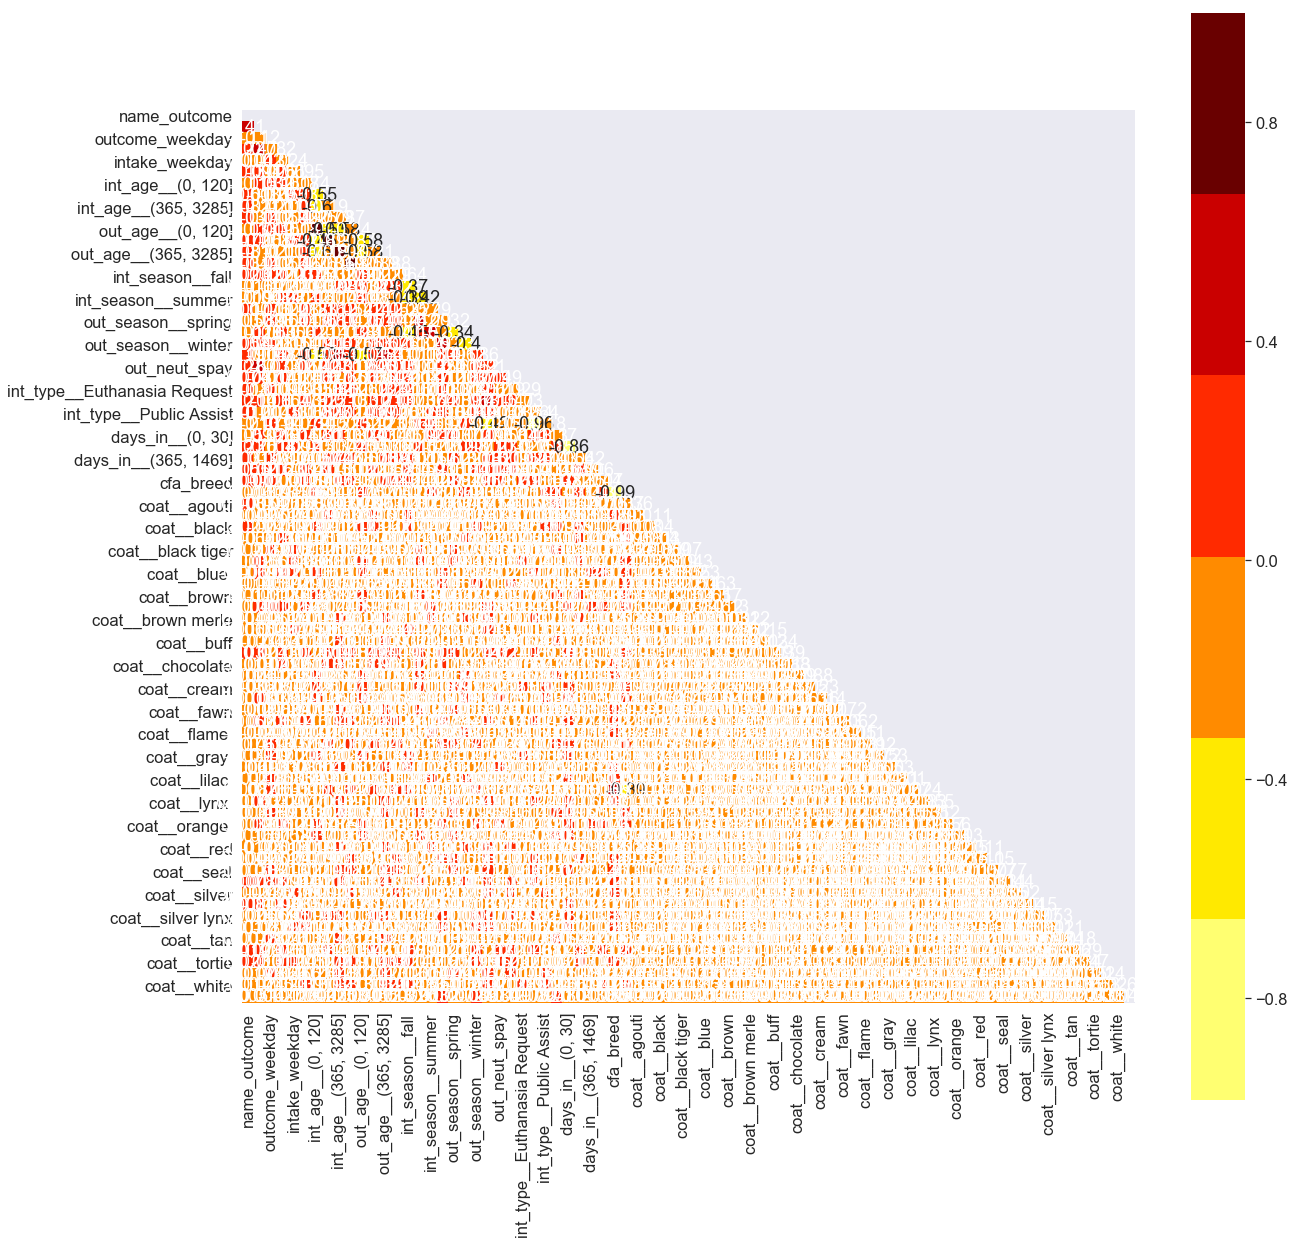

In [92]:
#Plots a heatmap of correlation between features with masking
fig, ax = plt.subplots(figsize=(20,20))
mask=np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
color_map = sns.color_palette("hot_r")
ax = sns.heatmap(df.corr(), cmap = color_map, mask=mask, square=True, annot=True)

In [93]:
# Find index of feature columns with correlation greater than 0.95
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['out_age__(365, 3285]',
 'out_age__(3285, 8030]',
 'int_type__Stray',
 'domestic_breed']

## Handling  Class Imbalance and Running a Classification Model

In [74]:
# features from baseline model are best features

In [75]:
len(features.columns)

77

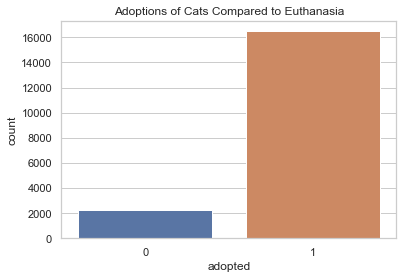

In [76]:
sns.countplot(df['adopted'])
plt.title('Adoptions of Cats Compared to Euthanasia')
plt.show()

In [77]:
#concatenate our training data back together

training = pd.concat([X_train, y_train], axis=1)

#separate minority and majority classes

euth = training[training['adopted'] == 0]
adopt = training[training['adopted'] == 1]

In [78]:
#get a class count to understand the class imbalance

print('Euthanasia Count: ' + str(len(euth)))
print('Adoption Count: ' + str(len(adopt)))

Euthanasia Count: 1819
Adoption Count: 13197


In [79]:
# Over-Sampling: SMOTE and Logistic Regression Model

sm = SMOTE(random_state=17, ratio=1.0)
X_resampled1, y_resampled1 = sm.fit_sample(X_train, y_train)

smote_lr = LogisticRegression(solver='liblinear')
smote_lr.fit(X_resampled1, y_resampled1)
smote_pred = smote_lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))
print('Test F1 score: ', f1_score(y_test, smote_pred))

print(confusion_matrix(y_test, smote_pred))
print(classification_report(y_test, smote_pred))

# smote_dt = DecisionTreeClassifier(max_depth=5)
# smote_dt.fit(X_resampled1, y_resampled1)
# smote_pred = smote_dt.predict(X_test)
# checking accuracy
# checking accuracy

Test Accuracy score:  0.9547149706979222
Test F1 score:  0.9739822467095195
[[ 402   59]
 [ 111 3182]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       461
           1       0.98      0.97      0.97      3293

   micro avg       0.95      0.95      0.95      3754
   macro avg       0.88      0.92      0.90      3754
weighted avg       0.96      0.95      0.96      3754



In [80]:
# Under-Sampling: Tomek Links and Logistic Regression Model

tl = TomekLinks()
X_resampled2, y_resampled2 = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled2))

# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled2, y_resampled2, idx_resampled = tl.fit_sample(X_resampled2, y_resampled2)

tomek_lr = LogisticRegression()
tomek_lr.fit(X_resampled2, y_resampled2)
tomek_pred = tomek_lr.predict(X_test)
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))
# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

print(confusion_matrix(y_test, tomek_pred))
print(classification_report(y_test, tomek_pred))

Resampled dataset shape Counter({1: 13118, 0: 1819})
Test Accuracy score:  0.9669685668620138
Test F1 score:  0.9813589897775105
[[ 366   95]
 [  29 3264]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       461
           1       0.97      0.99      0.98      3293

   micro avg       0.97      0.97      0.97      3754
   macro avg       0.95      0.89      0.92      3754
weighted avg       0.97      0.97      0.97      3754



## Run Different Models With Gridsearch for Hyperparameter Tuning

Going with downsampling TOMEK - slightly better accuracy (X_resampled2, y_resampled2)

### Decision Tree

In [106]:
# creating our parameters to test
parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,20,1)}
#create our estimaor
clf_tree=DecisionTreeClassifier(random_state=1)
#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='accuracy', verbose=2)
#fit the Gridsearch to our data
grid_tree.fit(X_resampled2,y_resampled2)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=2, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=35 ................
[CV] .

[CV] . criterion=gini, max_depth=3, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV] . criterion=gini, max_depth=3, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=4, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV] .

[CV] . criterion=gini, max_depth=5, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=65, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=80 ................
[CV] . criterion=gini, max_depth=5, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=5, min_samples_leaf=95 ................
[CV] .

[CV] . criterion=gini, max_depth=7, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=35, total=   0.1s
[CV] criterion=gini, max_depth=7, min_samples_leaf=35 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=7, min_samples_leaf=50 ................
[CV] . criterion=gini, max_depth=7, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=50 ................
[CV] .

[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] . criterion=gini, max_depth=9, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=20 ................
[CV] .

[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, total=   0.1s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  

[CV]  criterion=gini, max_depth=12, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=12, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=12, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=12, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=65, total=   0.1s
[CV] criterion=gini, max_depth=12, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=65, total=   0.1s
[CV] criterion=gini, max_depth=12, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=65, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=65 ...............
[CV]  

[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, total=   0.1s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=35, total=   0.1s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  

[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, total=   0.1s
[CV] criterion=gini, max_depth=15, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=95, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=16, min_samples_leaf=5, total=   0.1s
[CV] criterion=gini, max_depth=16, min_samples_leaf=5 ................
[CV] .

[CV]  criterion=gini, max_depth=17, min_samples_leaf=65, total=   0.1s
[CV] criterion=gini, max_depth=17, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=65, total=   0.1s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=17, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=80, total=   0.1s
[CV] criterion=gini, max_depth=17, min_samples_leaf=95 ...............
[CV]  

[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.1s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.1s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=35, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=50, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=19, min_samples_leaf=50, total=   0.1s
[CV] criterion=gini, max_depth=19, min_samples_leaf=50 ...............
[CV]  

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=20 ..........

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=65, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=65, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 ......

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=65 ......

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=35 ........

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=95 ......

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=6

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=3

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=5, total=   0.1s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 ...

[CV]  criterion=entropy, max_depth=16, min_samples_leaf=65, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=80, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=95, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=9

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=35, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=5

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [107]:
# Examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.9674998324733632
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 20}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


In [108]:
#Predict the response for test dataset
y_pred = grid_tree.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))

F1: 0.9809108672779198
Accuracy: 0.9661694192860948
Precision: 0.9711309523809524
Recall: 0.990889766170665
[[ 364   97]
 [  30 3263]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       461
           1       0.97      0.99      0.98      3293

   micro avg       0.97      0.97      0.97      3754
   macro avg       0.95      0.89      0.92      3754
weighted avg       0.97      0.97      0.97      3754



In [109]:
# Sensitivity of model: Percentage of positives correctly identified
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))

# Specificity of the model: Percentage of negatives correctly identified
print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The sensitivity is: 0.990889766170665
The specificity is: 0.789587852494577


The model has high sensitivity and ok specificity. This means that the model is very good at predicting both adoptions and is ok at predicting not adoptions.

False negatives (30 instances where the model predicted not adoption when it was an adoption) false positive (97 instances where the model predicted adoption when it wasn't an adoption)

### Random Forests

In [110]:
# run Random Forest with downsampled data

forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_resampled2, y_resampled2)
forest.predict(X_test)
#should I be using X_resampled and y_resampled?

#y_pred = forest.fit(X_resampled1, y_resampled1.predict(X_resampled1))

#accuracy score for training data
print(forest.score(X_resampled2, y_resampled2))
#accuracy score for testing data
print(forest.score(X_test, y_test))

# print("F1:",metrics.f1_score(y_test, y_pred))
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision:",metrics.precision_score(y_test, y_pred))
# print("Recall:",metrics.recall_score(y_test, y_pred))


print(cross_val_score(forest, features, target, cv=5))

0.9417007304161361
0.9403303143313798
[0.94299414 0.94619073 0.93633458 0.93100693 0.951252  ]


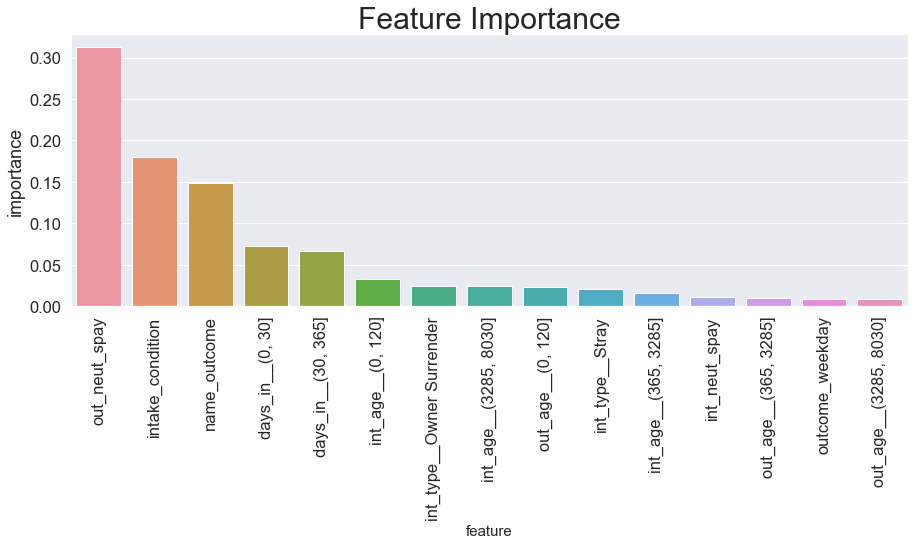

In [111]:
feature_importances = forest.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': features.columns}, 
                           index=features.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.title('Feature Importance', fontsize=30)
sns.barplot(x='feature', y='importance', data=importances[0:15])

### Logistic Regression

In [112]:
lr_clf = LogisticRegression()
parameters = {'penalty':['l1', 'l2'],
             'C': [.5,1,.1]}
grid_lr=GridSearchCV(estimator=lr_clf, param_grid=parameters, cv=5, scoring='accuracy')
grid_lr.fit(X_resampled2, y_resampled2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.5, 1, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [113]:
# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)

0.9701802586611271
{'C': 1, 'penalty': 'l1'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [114]:
#Predict the response for test dataset
y_pred_lr = grid_lr.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred_lr))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

F1: 0.9812001804782674
Accuracy: 0.9667021843367075
Precision: 0.9719904648390941
Recall: 0.9905860917096873
[[ 367   94]
 [  31 3262]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       461
           1       0.97      0.99      0.98      3293

   micro avg       0.97      0.97      0.97      3754
   macro avg       0.95      0.89      0.92      3754
weighted avg       0.97      0.97      0.97      3754



### KNN

In [115]:
# # Run a KNN Model with the Resampled Data
knn = KNeighborsClassifier(metric='euclidean')
parameters = {'n_neighbors':[1,2,3,4,5],
              'weights':['uniform', 'distance'], 
              'leaf_size':[15,30],
              'p':[1,2]}
grid_knn=GridSearchCV(estimator = knn, param_grid=parameters, cv=5, scoring='accuracy', verbose=2)
grid_knn.fit(X_resampled2, y_resampled2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] leaf_size=15, n_neighbors=1, p=1, weights=uniform ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  leaf_size=15, n_neighbors=1, p=1, weights=uniform, total=   3.7s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=uniform ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV]  leaf_size=15, n_neighbors=1, p=1, weights=uniform, total=   3.1s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=uniform, total=   3.3s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=uniform, total=   3.2s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=uniform, total=   3.2s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=distance, total=   3.2s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=distance, total=   3.1s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=1, p=1, weights=distance, total=   3.3s
[CV] leaf_size=15, n_neighbors=1, p=1, weights=distance ..............
[CV

[CV]  leaf_size=15, n_neighbors=3, p=2, weights=distance, total=   4.8s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=uniform, total=   5.4s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=uniform, total=   5.4s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=uniform, total=   5.5s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=uniform, total=   7.1s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=uniform ...............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=uniform, total=   6.0s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=distance ..............
[CV]  leaf_size=15, n_neighbors=4, p=1, weights=distance, total=   5.3s
[CV] leaf_size=15, n_neighbors=4, p=1, weights=distance ..............
[CV]

[CV]  leaf_size=30, n_neighbors=1, p=2, weights=distance, total=   3.5s
[CV] leaf_size=30, n_neighbors=1, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=1, p=2, weights=distance, total=   3.4s
[CV] leaf_size=30, n_neighbors=1, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=1, p=2, weights=distance, total=   3.5s
[CV] leaf_size=30, n_neighbors=2, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=2, p=1, weights=uniform, total=   4.3s
[CV] leaf_size=30, n_neighbors=2, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=2, p=1, weights=uniform, total=   4.2s
[CV] leaf_size=30, n_neighbors=2, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=2, p=1, weights=uniform, total=   4.2s
[CV] leaf_size=30, n_neighbors=2, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=2, p=1, weights=uniform, total=   4.2s
[CV] leaf_size=30, n_neighbors=2, p=1, weights=uniform ...............
[CV

[CV]  leaf_size=30, n_neighbors=4, p=2, weights=distance, total=   5.9s
[CV] leaf_size=30, n_neighbors=4, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=4, p=2, weights=distance, total=   5.5s
[CV] leaf_size=30, n_neighbors=4, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=4, p=2, weights=distance, total=   5.0s
[CV] leaf_size=30, n_neighbors=4, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=4, p=2, weights=distance, total=   4.9s
[CV] leaf_size=30, n_neighbors=4, p=2, weights=distance ..............
[CV]  leaf_size=30, n_neighbors=4, p=2, weights=distance, total=   5.0s
[CV] leaf_size=30, n_neighbors=5, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=5, p=1, weights=uniform, total=   5.3s
[CV] leaf_size=30, n_neighbors=5, p=1, weights=uniform ...............
[CV]  leaf_size=30, n_neighbors=5, p=1, weights=uniform, total=   5.3s
[CV] leaf_size=30, n_neighbors=5, p=1, weights=uniform ...............
[

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 72.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance'], 'leaf_size': [15, 30], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [116]:
# # Single best score achieved across all params (min_samples_split)
print(grid_knn.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_knn.best_params_)

0.958252362125578
{'leaf_size': 15, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


In [117]:
# #Predict the response for test dataset
y_pred_knn = grid_knn.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred_knn))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))
print("Precision:",metrics.precision_score(y_test, y_pred_knn))
print("Recall:",metrics.recall_score(y_test, y_pred_knn))

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

F1: 0.9750825577904533
Accuracy: 0.9557805007991476
Precision: 0.9640842980112793
Recall: 0.9863346492559976
[[ 340  121]
 [  45 3248]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       461
           1       0.96      0.99      0.98      3293

   micro avg       0.96      0.96      0.96      3754
   macro avg       0.92      0.86      0.89      3754
weighted avg       0.95      0.96      0.95      3754

